In [2]:
# from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import copy
import json

# drive.mount('/content/drive')

# Specifying the path to JSON files
Q_path = 'phase_2_Q_table.json'
policy_1_path = 'phase_2_policy_player_1.json'
policy_2_path = 'phase_2_policy_player_2.json'

In [3]:
class TicTacToe:
    def __init__(self):
        self.board = [[" " for _ in range(4)] for _ in range(4)]
        self.current_player = -1


    def check_draw(self):
        for row in self.board:
            if " " in row:
                return False
        return True

    def print_board(self):
        # Prints a GUI-like representation of the board
        print("┌───┬───┬───┬───┐")
        for i, row in enumerate(self.board):
            print("│ " + " │ ".join(row) + " │")
            if i < 3:
                print("├───┼───┼───┼───┤")
        print("└───┴───┴───┴───┘")

    def check_winner(self, player):
        for row in self.board:
            if all([cell == player for cell in row]):
                return True
        for col in range(4):
            if all([self.board[row][col] == player for row in range(4)]):
                return True
        if all([self.board[i][i] == player for i in range(4)]) or all(
            [self.board[i][3 - i] == player for i in range(4)]
        ):
            return True
        return False

    def step(self, state):
        row = int(state / 4)
        col = int(state % 4)

        current_player_symbol = " "
        if self.current_player == -1:
            current_player_symbol = "X"
        else:
            current_player_symbol = "O"

        if self.board[row][col] == " ":
            self.board[row][col] = current_player_symbol

        if self.check_winner("O"):
            return self.board, self.current_player, True, 1
        elif self.check_winner("X"):
            return self.board, self.current_player, True, -1
        elif self.check_draw():
            return self.board, self.current_player, True, 0

        self.current_player *= -1

        return self.board, self.current_player, False, 0

In [4]:
# Helper function to choose random action for the agent
def rand_policy(board):

    possible_actions = []

    for i in range(4):
        for j in range(4):
            if board[i][j] == " ":
                possible_actions.append(i * 4 + j)

    return random.choice(possible_actions)

# Helper function to add a new state discovered by the agent
def add_new_state(Q_table, board):
    possible_actions = []
    for i in range(4):
        for j in range(4):
            if board[i][j] == " ":
                possible_actions.append(i * 4 + j)

    possible_actions = dict.fromkeys(possible_actions, 0.0)
    board = tuple(map(tuple, board))

    Q_table[board] = possible_actions

    return Q_table

# Helper function for action selection using epsilon greedy
def epsilon_greedy(Q_table, state, player, epsilon):
    state =  tuple(map(tuple, state))
    rand = random.uniform(0, 1)
    if rand > epsilon:
        if player == 1:
            action = max(Q_table[state], key=Q_table[state].get)
        elif player == -1:
            action = min(Q_table[state], key=Q_table[state].get)
    else:
        action = random.choice(list(Q_table[state].keys()))

    return action

# Helper funtion for epsilon decay
def get_epsilon(epsilon, iter, total_iterations, explore_exploit_ratio, min_epsilon, max_epsilon, decay_factor):
    cutoff = explore_exploit_ratio * total_iterations
    if iter < cutoff:
        epsilon = max_epsilon
    else:
        epsilon = (min_epsilon - max_epsilon) * ((iter - cutoff)/ (total_iterations - cutoff)) ** decay_factor + max_epsilon
    return epsilon

# Helper function to retrieve the policy for Player 1 from Q table
def get_policy_player_1(Q):
    policy = {}
    for state, actions in Q.items():

        len_X = sum(row.count('X') for row in state)
        len_O = sum(row.count('O') for row in state)

        if len_X <= len_O:
            if all(value == 0.0 for value in actions.values()):
                policy[state] = int(random.choice(list(actions.keys())))
            else:
                policy[state] = int(min(actions, key=actions.get))

    return policy

# Helper function to retrieve the policy for Player 2 from Q table
def get_policy_player_2(Q):
    policy = {}
    for state, actions in Q.items():

        len_X = sum(row.count('X') for row in state)
        len_O = sum(row.count('O') for row in state)

        if len_X > len_O:
            if all(value == 0.0 for value in actions.values()):
                policy[state] = int(random.choice(list(actions.keys())))
            else:
                policy[state] = int(max(actions, key=actions.get))

    return policy

In [5]:
# Function to convert tuples to strings
def tuple_to_string(t):
    return str(t)

# Function to write files in directory
def write_file(path, table):
    serialized_table = {tuple_to_string(key): value for key, value in table.items()}

    with open(path, 'w') as w_file:
        json.dump(serialized_table, w_file, indent=2)

# Function to read files in directory
def read_file(path):
    with open(path, 'r') as r_file:
        table = json.load(r_file)

    # Convert string keys back to tuples
    table = {tuple(eval(key)): value for key, value in table.items()}
    return table

In [38]:
# Function to run Q-Learning using TD(0) rule
def run_q_learning(N, max_epsilon, min_epsilon, decay_factor, gamma, alpha_decay, ee_ratio):
    Q = {}
    state = [[" " for _ in range(4)] for _ in range(4)]
    Q = add_new_state(Q, state)

    epsilon = max_epsilon
    alpha = 0.7

    for i in range(N):
        tictactoe = TicTacToe()
        state_1 = [[" " for _ in range(4)] for _ in range(4)]
        s_1 =  tuple(map(tuple, state_1))
        terminated = False

        for j in range(8):
            if terminated:
                break

            for turn in [-1, 1]:
                if not terminated:
                    if turn == -1:
                        u_1 = epsilon_greedy(Q, state_1, turn, epsilon)

                        if j == 0:
                            state_2, _, terminated, reward_1 = tictactoe.step(u_1)
                            s_2 = tuple(map(tuple, state_2))
                            if not s_2 in Q:
                                Q = add_new_state(Q, state_2)
                        else:
                            next_state_2, _, terminated, reward_1 = tictactoe.step(u_1)
                            ns_2 = tuple(map(tuple, next_state_2))
                            s2 = s_2

                            if not (ns_2 in Q or terminated):
                                Q = add_new_state(Q, next_state_2)

                            state_2 = copy.deepcopy(next_state_2)
                            s_2 = tuple(map(tuple, state_2))

                            if terminated and reward_1 == -1:
                                Q[s_1][u_1] = (1 - alpha) * Q[s_1][u_1] + alpha * reward_1

                    elif turn == 1:
                        u_2 = epsilon_greedy(Q, state_2, turn, epsilon)

                        next_state_1, _, terminated, reward_2 = tictactoe.step(u_2)
                        ns_1 = tuple(map(tuple, next_state_1))
                        s1 = s_1

                        if not (ns_1 in Q or terminated):
                            Q = add_new_state(Q, next_state_1)

                        state_1 = copy.deepcopy(next_state_1)
                        s_1 = tuple(map(tuple, state_1))

                        if terminated and reward_2 == 1:
                            Q[s_2][u_2] = (1 - alpha) * Q[s_2][u_2] + alpha * reward_2

            if not terminated:
                if ns_1 in Q:
                    Q[s1][u_1] = (1 - alpha) * Q[s1][u_1] + alpha * gamma * min(Q[ns_1].values())

                if j != 0:
                    if ns_2 in Q:
                        Q[s2][u_2] = (1 - alpha) * Q[s2][u_2] + alpha * gamma * max(Q[ns_2].values())

        alpha = alpha_decay * alpha
        epsilon = get_epsilon(epsilon, i, N, ee_ratio, min_epsilon, max_epsilon, decay_factor)

    return Q

In [39]:
# Perform Q-learning with the following hyper-parameters
N = 4000000
max_epsilon = 1.0
min_epsilon = 0.01
decay_factor = 0.5
gamma = 0.999
alpha_decay = 0.9999993
ee_ratio = 0.75

Q = run_q_learning(N, max_epsilon, min_epsilon, decay_factor, gamma, alpha_decay, ee_ratio)

# Save the Q table in directory
write_file(Q_path, Q)

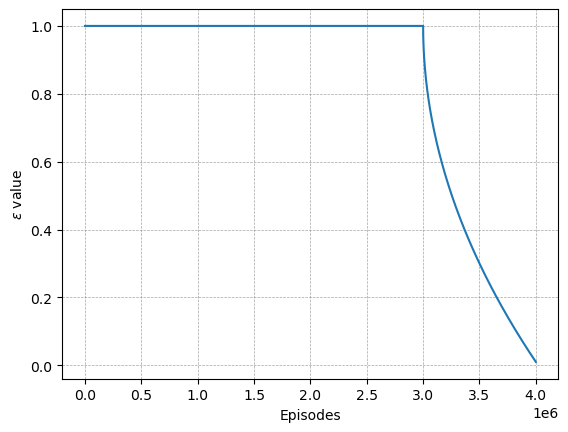

In [38]:
# Rough work for deciding epsilon decay rate
eps = []
ep_o = 1.0
ep_N = 0.01
eta = 0.5
N = 4000000
e = ep_o

for i in range(N):
    e = get_epsilon(e, i, N, 0.75, ep_N, ep_o, eta)
    eps.append(e)

plt.plot(eps)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.xlabel('Episodes')
plt.ylabel('$\epsilon$ value')
plt.savefig('my_plot.png')

In [6]:
# Read Q-table stored in the directory
Q_table = read_file(Q_path)

# Compute policy for player 1
policy_1 = get_policy_player_1(Q_table)

# Compute policy for player 2
policy_2 = get_policy_player_2(Q_table)

# Save the policy tables in directory
write_file(policy_1_path, policy_1)
write_file(policy_2_path, policy_2)

In [7]:
print(len(Q_table), len(policy_1), len(policy_2))

7962087 4072733 3889354


In [8]:
def play_one_game(policy_player1, policy_player2):
    tictactoe = TicTacToe()
    terminated = 0
    board = [[" " for _ in range(4)] for _ in range(4)]

    for i in range(8):
        for turn in [-1, 1]:
            action = 0
            # Uncomment this if you want to see the board
            # tictactoe.print_board()

            if turn == -1:
                if tuple(map(tuple, board)) not in policy_player1:
                    action = rand_policy(board)
                else:
                    aciton = policy_player1[tuple(map(tuple, board))]
            else:
                if tuple(map(tuple, board)) not in policy_player2:
                    action = rand_policy(board)
                else:
                    action = policy_player2[tuple(map(tuple, board))]

            board, player, terminated, reward = tictactoe.step(action)

            if terminated:
                break

    return reward # This is the player who won

In [9]:
def run_alternating_games(games=10):
    results = []
    for i in range(games):
        for j in range(2):
            if j==0:
                winner = play_one_game(policy_1, policy_2)

                match winner:
                    case -1:
                        results.append(1)
                    case 1:
                        results.append(2)
                    case 0:
                        results.append(0)

            if j==1:
                winner = play_one_game(policy_2, policy_1)

                match winner:
                    case -1:
                        results.append(2)
                    case 1:
                        results.append(1)
                    case 0:
                        results.append(0)

    return results

In [30]:
results = run_alternating_games(1000)
print("Draws: ", results.count(0))
print("Player 1 Wins:", results.count(1))
print("Player 2 Wins:", results.count(2))

Draws:  1014
Player 1 Wins: 402
Player 2 Wins: 584
